In [1]:
pwd

'/Users/yueying.teng/Documents/text_object_detection'

In [13]:
root = '/Users/yueying.teng/Documents/text_object_detection/'

In [2]:
import pandas as pd
import numpy as np
import re
import os 
from PIL import Image 


### resize images while keeping aspect ratio

In [87]:
img_dir = root + 'images_full_size/'

img_path = [img_dir + i for i in sorted(os.listdir(img_dir))]

# resize to the following size 
size = 500, 300
outfile = root + 'images/'

for i in range(len(img_path)):
    try:
        im = Image.open(img_path[i])
        im.thumbnail(size, Image.ANTIALIAS)
        im.save(outfile + sorted(os.listdir(img_dir))[i])

    except OSError:
        continue
        

In [81]:
# img_dir = root + 'images_full_size/'

# img_path = [img_dir + i for i in sorted(os.listdir(img_dir))]


# # size is a width, height tuple 
# size = (300, 500)
# for i in range(len(img_path)):
#     try:
#         img = Image.open(img_path[i])
#         # Get current and desired ratio for the images
#         img_ratio = img.size[0] / float(img.size[1])
#         ratio = size[0] / float(size[1])
#         # The image is scaled/cropped vertically or horizontally depending on the ratio
#         if ratio > img_ratio:
#             img = img.resize((size[0], size[0] * img.size[1] / img.size[0]), Image.ANTIALIAS)
#             img.save(outfile + sorted(os.listdir(img_dir))[i])
            
#     except OSError:
#         continue

### change label.csv format 

In [139]:
# the following is the resized hello labeled data 

df = pd.read_csv('./data/labelbox_resized_hello.csv')

# fill in the external id column 
df['id'] =  sorted(os.listdir(img_dir))

df.rename(columns = {'Label': 'label'}, inplace = True)

# remove duplication in id
df = df[~ df.duplicated('id', keep = 'first')]

df.head()


,ID,Labeled Data,label,Created By,Project Name,Created At,Seconds to Label,External ID,Agreement,id
0,cjitz4t8p0p4207215wmy9m23,https://firebasestorage.googleapis.com/v0/b/la...,"{""hello"":[[{""x"":181,""y"":177},{""x"":181,""y"":78},...",yueyingteng@gmail.com,resized_hello,1529913730000,8.176,NaN,NaN,IMG_0258.JPG
1,cjitzgo4u0rd20721pm5v70o8,https://firebasestorage.googleapis.com/v0/b/la...,"{""hello"":[[{""x"":215,""y"":161},{""x"":215,""y"":73},...",yueyingteng@gmail.com,resized_hello,1529914283000,4.949,NaN,NaN,IMG_0260.JPG
2,cjitz50hu0p4y0721qsnj294e,https://firebasestorage.googleapis.com/v0/b/la...,"{""hello"":[[{""x"":194,""y"":171},{""x"":194,""y"":66},...",yueyingteng@gmail.com,resized_hello,1529913740000,9.442,NaN,NaN,IMG_0261.JPG
3,cjitz5am50p6e0721y6j5z3ed,https://firebasestorage.googleapis.com/v0/b/la...,"{""hello"":[[{""x"":209,""y"":123},{""x"":209,""y"":70},...",yueyingteng@gmail.com,resized_hello,1529913753000,13.105,NaN,NaN,IMG_0262.JPG
4,cjitz5mnz0vcd0749lvja4r1h,https://firebasestorage.googleapis.com/v0/b/la...,"{""hello"":[[{""x"":226,""y"":138},{""x"":197,""y"":139}...",yueyingteng@gmail.com,resized_hello,1529913768000,15.604,NaN,NaN,IMG_0264.JPG


In [140]:
df.shape

(173, 10)

In [141]:
# find width and height of all images in External ID

# training 
img_dir = root + 'images/'
img_files = df['id']
w = []
h = []
files = []
xmin = []
ymin = []
xmax = []
ymax = []

for i in range(len(img_files)):
    try:
        image_path = os.path.join(img_dir, img_files[i])
        image_obj = Image.open(image_path)
        
        # get image width and height 
        w.append(image_obj.width)
        h.append(image_obj.height)
        files.append(img_files[i])
        
        # get coordinates
        string =  df['label'].iloc[i]
        # match all numbers in lable column which has coordinates for all four corners with bottom left corner as origin
        match = re.findall(r'\:\d+', string)
        # xmin is 1812
        match1 = re.findall(r'\d+', match[0])
        xmin.append(int(match1[0]))
        # ymin is H-1792
        match2 = re.findall(r'\d+', match[1])
        ymin.append(image_obj.height - int(match2[0]))
        # xmax is 2061
        match3 = re.findall(r'\d+', match[4])
        xmax.append(int(match3[0]))
        # ymax is H-785
        match4 = re.findall(r'\d+', match[3])
        ymax.append(image_obj.height - int(match4[0]))

    except KeyError: 
        continue 

In [142]:
classes = ['hello'] * len(files)

out = pd.DataFrame({'filename': files, 'width': w, 'height': h, 'class': classes, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax},\
                  columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
out.head()

out.to_csv('./data/hello_label_wrong.csv', index = None)


In [143]:
# this csv contains picutres with incorrect bounding boxes. 
df2 = pd.read_csv('./data/hello_label_wrong.csv')

df2.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_0258.JPG,400,300,hello,181,123,203,222
1,IMG_0260.JPG,400,300,hello,215,139,243,227
2,IMG_0261.JPG,400,300,hello,194,129,217,234
3,IMG_0262.JPG,400,300,hello,209,177,234,230
4,IMG_0264.JPG,400,300,hello,226,162,197,161


### label quality check 

In [145]:
# make sure xmin has to be smaller than xmax
wrong = []
for i in range(df2.shape[0]):
    if df2.iloc[i]['xmin'] > df2.iloc[i]['xmax']:
        wrong.append(i)
    elif df2.iloc[i]['ymin'] > df2.iloc[i]['ymax']:
        wrong.append(i)

In [146]:
wrong, len(wrong)

([4, 13, 37, 38, 43, 61, 67, 74, 101, 104, 117, 139, 169], 13)

In [150]:
# print the wrong image names - these images will not be used in training but can be used in testig 

df2.iloc[wrong, :]

,filename,width,height,class,xmin,ymin,xmax,ymax
4,IMG_0264.JPG,400,300,hello,226,162,197,161
13,IMG_0274.JPG,400,300,hello,184,184,207,95
37,IMG_0333.JPG,400,300,hello,196,218,224,111
38,IMG_0335.JPG,400,300,hello,231,171,204,171
43,IMG_0344.JPG,400,300,hello,214,148,188,148
61,IMG_0379.JPG,400,300,hello,216,145,191,144
67,IMG_0392.JPG,400,300,hello,209,152,184,152
74,IMG_0428.JPG,400,300,hello,230,123,202,123
101,IMG_0516.JPG,400,300,hello,221,130,192,130
104,IMG_0528.JPG,400,300,hello,203,100,174,99


In [118]:
# make sure bounding boxes are not outside the image boundaries
out = []
for i in range(df2.shape[0]):
    if df2.iloc[i]['xmin'] > df2.iloc[i]['width']:
        out.append(i)
    elif df2.iloc[i]['xmax'] > df2.iloc[i]['width']:
        out.append(i)
    elif df2.iloc[i]['ymin'] > df2.iloc[i]['height']:
        out.append(i)
    elif df2.iloc[i]['ymax'] > df2.iloc[i]['height']:
        out.append(i)

In [119]:
out

[]

In [105]:
# check the sizes of the bounding boxes

negative = []
for i in range(df2.shape[0]):
    if df2.iloc[i]['xmax'] - df2.iloc[i]['xmin'] < 0:
        negative.append(i)
    elif df2.iloc[i]['ymax'] - df2.iloc[i]['ymin'] < 0:
        negative.append(i)

In [120]:
negative == wrong 

True

In [151]:
# remove the problematic images 

df2.drop(df2.index[wrong], inplace = True)

df2.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_0258.JPG,400,300,hello,181,123,203,222
1,IMG_0260.JPG,400,300,hello,215,139,243,227
2,IMG_0261.JPG,400,300,hello,194,129,217,234
3,IMG_0262.JPG,400,300,hello,209,177,234,230
5,IMG_0265.JPG,400,300,hello,212,146,239,204


In [152]:
# save the corrected label csv 

df2.to_csv('./data/hello_label.csv', index = None)

### split label to training and testing data 

In [126]:
# grouped = df2.groupby('filename')
# grouped.apply(lambda x: len(x)).value_counts()

# split each file into a group in a list
gb = df2.groupby('filename')

grouped_list = [gb.get_group(x) for x in gb.groups]

# gb.groups is a dictionary 
print (gb.get_group('IMG_0258.JPG'))

len(grouped_list)


       filename  width  height  class  xmin  ymin  xmax  ymax
0  IMG_0258.JPG    400     300  hello   181   123   203   222


160

In [128]:
df2.shape

(160, 8)

In [129]:

# split filenames to train test groups
train_index = np.random.choice(len(grouped_list), size=135, replace=False)
# np.setdiff1d - Find the set difference of two arrays.
test_index = np.setdiff1d(list(range(160)), train_index)

print (len(train_index), len(test_index))

# group datasets using index
train = pd.concat([grouped_list[i] for i in train_index])
test = pd.concat([grouped_list[i] for i in test_index])

print (len(train), len(test))

train.to_csv('./data/train_labels.csv', index=None)
test.to_csv('./data/test_labels.csv', index=None)


135 25
135 25


### draw boxes

In [130]:

def draw_boxes(image_name):
    selected_value = full_labels[full_labels.filename == image_name]
    img = cv2.imread('images/{}'.format(image_name))
    for index, row in selected_value.iterrows():
        img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 3)
    return img

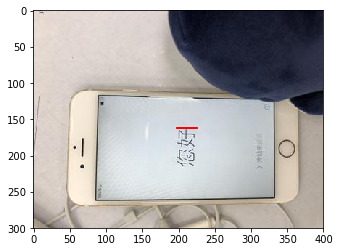

In [132]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


one_dir = root + 'images/IMG_0264.JPG'
im = np.array(Image.open(one_dir), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch 
# rect = patches.Rectangle((1772, 1230), 2110 - 1772, 2280 - 1230,linewidth=1,edgecolor='r',facecolor='none')
rect = patches.Rectangle((226, 162), 197 - 226, 161 - 162 , linewidth = 1, edgecolor = 'r', facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [88]:
string = df['label'].iloc[0]
print (string)

match = re.findall(r'\:\d+', string)
print (match)

# xmin is 1812
match1 = re.findall(r'\d+', match[0])
int(match1[0])

# ymin is H-1792
match2 = re.findall(r'\d+', match[1])
int(match2[0])

# xmax is 2061
match3 = re.findall(r'\d+', match[4])
int(match3[0])

# ymax is H-785
match4 = re.findall(r'\d+', match[3])
int(match4[0])

{"Hello":[[{"x":1812,"y":1792},{"x":1812,"y":785},{"x":2061,"y":785},{"x":2061,"y":1792}]]}


[':1812', ':1792', ':1812', ':785', ':2061', ':785', ':2061', ':1792']